## Future Sales Forecast

In [1]:
import matplotlib
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn')
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

Importing plotly failed. Interactive plots will not work.


#### Load Datasets

In [2]:
# Carregamento dos datasets.
items = pd.read_csv('datasets/items.csv')
sales = pd.read_csv('datasets/sales.csv')
items_categories = pd.read_csv('datasets/item_categories.csv')

In [3]:
# Dataset 'sales'.
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Data Processing

In [4]:
# Registros com valores negativos nas colunas 'item_price' e 'item_cnt_day'.
sales[sales['item_price'] < 0]
sales[sales['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [5]:
# Invertendo o 'sinal' dos valores negativos.
sales.loc[sales['item_price'] < 0, 'item_price'] *= -1
sales.loc[sales['item_cnt_day'] < 0, 'item_cnt_day'] *= -1

In [6]:
# Dataset corrigido/atualizado.
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
# Convertendo a coluna 'date' para o formato 'datetime'.
sales['date'] = sales['date'].apply(lambda d: pd.datetime.strptime(d, '%d.%m.%Y'))

In [8]:
# Criação das colunas 'year' (ano), 'month' (mês) e 'total_value' (valor total).
sales['year'] = sales['date'].apply(lambda d: d.year)
sales['month'] = sales['date'].apply(lambda d: d.month)
sales['total_value'] = sales['item_price'] * sales['item_cnt_day']

In [9]:
# Adicionando a coluna 'item_category_id' ao dataset 'sales'.
sales = sales.set_index('item_id')\
    .join(items.set_index('item_id'))\
    .drop('item_name', axis=1).reset_index()

In [10]:
# Dataset 'sales' após o processamento/tratamento dos dados.
sales.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,year,month,total_value,item_category_id
0,0,2014-09-01,20,54,58.0,1.0,2014,9,58.0,40
1,1,2014-04-04,15,55,4490.0,1.0,2014,4,4490.0,76
2,1,2014-04-02,15,55,4490.0,1.0,2014,4,4490.0,76
3,1,2014-07-06,18,55,4490.0,1.0,2014,7,4490.0,76
4,1,2014-08-04,19,55,4490.0,1.0,2014,8,4490.0,76


### Data Analysis and Exploration

In [11]:
# Retorna o total mensal de receita e de vendas de acordo com o ano informado.
def monthly_sales_revenues_by_year(dataset, year):
    return dataset[dataset['year']==year]\
        .groupby(['month'])['item_cnt_day', 'total_value'].sum()

# Obtendo o total mensal de receita e de vendas dos anos de 2013, 2014 e 2015.
monthly_total_2013 = monthly_sales_revenues_by_year(sales, 2013)
monthly_total_2014 = monthly_sales_revenues_by_year(sales, 2014)
monthly_total_2015 = monthly_sales_revenues_by_year(sales, 2015)

In [12]:
 # Retorna a diferença (%) média entre os anos, dos 10 primeiros meses.
 def diff_mean_percent_years(column):
     diff = pd.DataFrame({
         2013: monthly_total_2013[column][:10],
         2014: monthly_total_2014[column][:10],
         2015: monthly_total_2015[column]
     }).pct_change(axis=1).mean() * 100

     print("2013-2014: {:.2f}%".format(diff[2014]))
     print("2014-2015: {:.2f}%".format(diff[2015]))

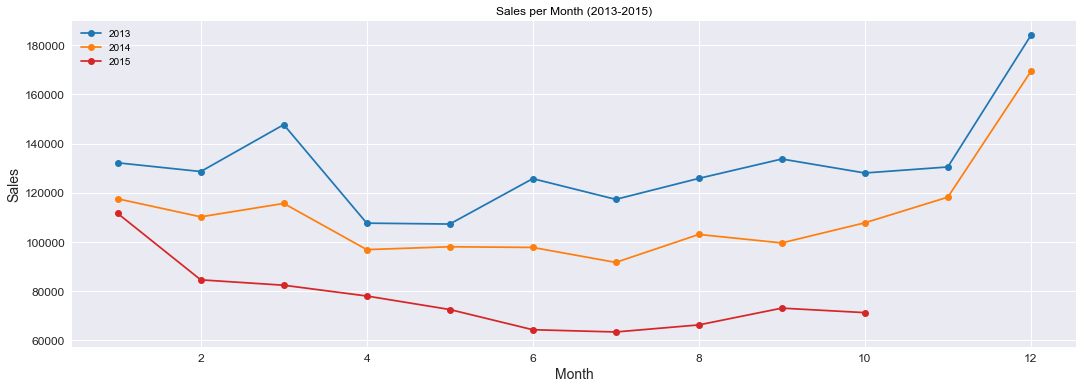

In [13]:
# Gráfico - Vendas por Mês (2013-2015)
fig, axs = plt.subplots(figsize=(18, 6))
axs.set_xlabel('Month')
axs.set_ylabel('Sales')
axs.set_title('Sales per Month (2013-2015)')
axs.plot(monthly_total_2013['item_cnt_day'], '-ok', color='tab:blue', label='2013')
axs.plot(monthly_total_2014['item_cnt_day'], '-ok', color='tab:orange', label='2014')
axs.plot(monthly_total_2015['item_cnt_day'], '-ok', color='tab:red', label='2015')
plt.legend()

In [14]:
# Retorna a diferença média das vendas entre os anos, em porcentagens.
diff_mean_percent_years('item_cnt_day')

2013-2014: -16.92%
2014-2015: -26.37%


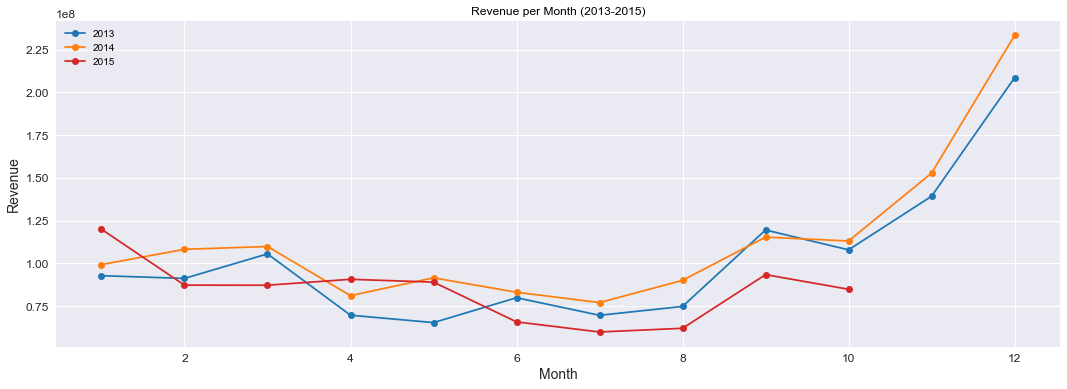

In [15]:
# Gráfico - Receita por Mês (2013-2015)
fig, axs = plt.subplots(figsize=(18, 6))
axs.set_xlabel('Month')
axs.set_ylabel('Revenue')
axs.set_title('Revenue per Month (2013-2015)')
axs.plot(monthly_total_2013['total_value'], '-ok', color='tab:blue', label='2013')
axs.plot(monthly_total_2014['total_value'], '-ok', color='tab:orange', label='2014')
axs.plot(monthly_total_2015['total_value'], '-ok', color='tab:red', label='2015')
plt.legend()

In [16]:
# Retorna a diferença média da receita entre os anos, em porcentagens.
diff_mean_percent_years('total_value')

2013-2014: 12.24%
2014-2015: -12.82%


In [17]:
total_sales = sales.groupby(['date_block_num'])['item_cnt_day', 'total_value'].sum()

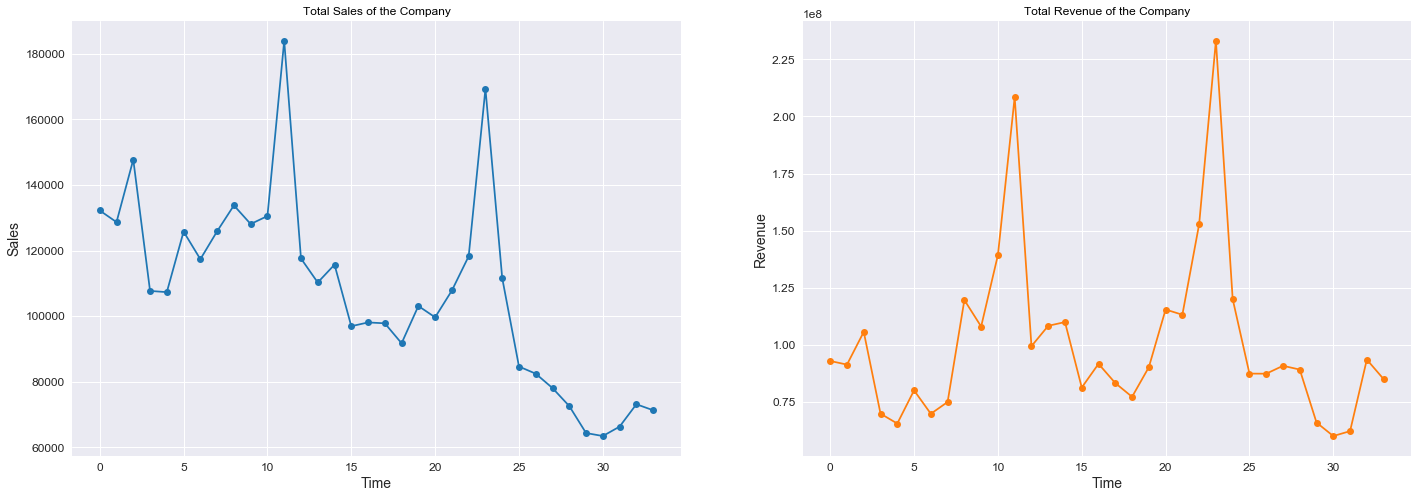

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

axs[0].set_xlabel('Time')
axs[0].set_ylabel('Sales')
axs[0].set_title('Total Sales of the Company')
axs[0].plot(total_sales['item_cnt_day'], '-ok', color='tab:blue')

axs[1].set_xlabel('Time')
axs[1].set_ylabel('Revenue')
axs[1].set_title('Total Revenue of the Company')
axs[1].plot(total_sales['total_value'], '-ok', color='tab:orange')

In [19]:
decomposition_sales = seasonal_decompose(total_sales['item_cnt_day'].values, freq=12)
decomposition_revenue = seasonal_decompose(total_sales['total_value'].values, freq=12)

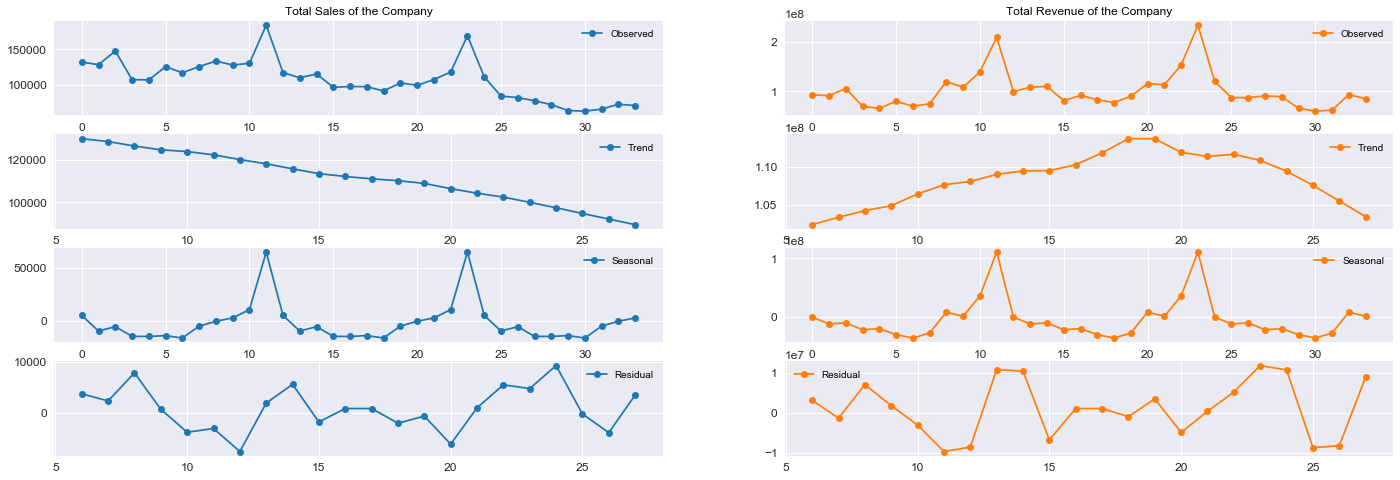

In [20]:
fig, axs = plt.subplots(4, 2, figsize=(24, 8))

axs[0][0].set_title('Total Sales of the Company')
axs[0][0].plot(total_sales['item_cnt_day'], '-ok', color='tab:blue', label='Observed')
axs[1][0].plot(decomposition_sales.trend, '-ok', color='tab:blue', label='Trend')
axs[2][0].plot(decomposition_sales.seasonal, '-ok', color='tab:blue', label='Seasonal')
axs[3][0].plot(decomposition_sales.resid, '-ok', color='tab:blue', label='Residual')

axs[0][1].set_title('Total Revenue of the Company')
axs[0][1].plot(total_sales['total_value'], '-ok', color='tab:orange', label='Observed')
axs[1][1].plot(decomposition_revenue.trend, '-ok', color='tab:orange', label='Trend')
axs[2][1].plot(decomposition_revenue.seasonal, '-ok', color='tab:orange', label='Seasonal')
axs[3][1].plot(decomposition_revenue.resid, '-ok', color='tab:orange', label='Residual')

for ax in axs.flat:
    ax.legend(loc='best')

In [21]:
stores_sales = sales.groupby(['shop_id'])['item_cnt_day'].agg(item_cnt_day='sum')
stores_sales = stores_sales.sort_values(by='item_cnt_day', ascending=False)

In [22]:
stores_more_sales = stores_sales.iloc[0:10] # TOP 10
stores_more_sales = stores_more_sales.sort_values(by='shop_id').reset_index()

stores_less_sales = stores_sales.iloc[-10:] # LAST 10
stores_less_sales = stores_less_sales.sort_values(by='shop_id').reset_index()

<BarContainer object of 10 artists>

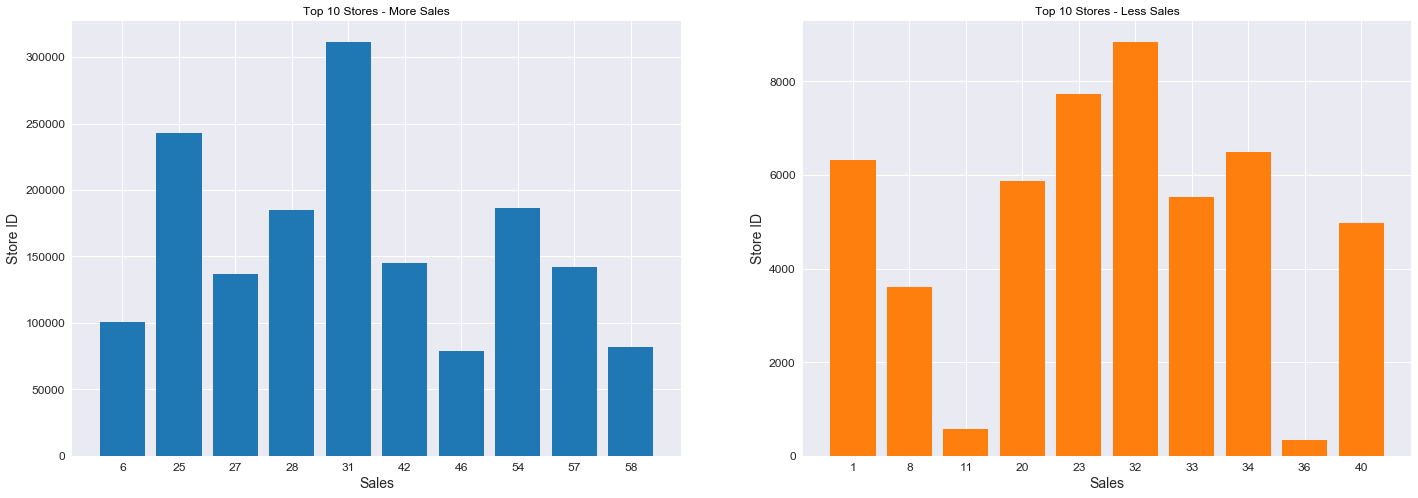

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

axs[0].set_xlabel('Sales')
axs[0].set_ylabel('Store ID')
axs[0].set_title('Top 10 Stores - More Sales')
axs[0].bar(stores_more_sales['shop_id'].astype('str'), stores_more_sales['item_cnt_day'], color='tab:blue')

axs[1].set_xlabel('Sales')
axs[1].set_ylabel('Store ID')
axs[1].set_title('Top 10 Stores - Less Sales')
axs[1].bar(stores_less_sales['shop_id'].astype('str'), stores_less_sales['item_cnt_day'], color='tab:orange')

In [24]:
stores_revenue = sales.groupby(['shop_id'])['total_value'].agg(total_value='sum')
stores_revenue = stores_revenue.sort_values(by='total_value', ascending=False)

In [25]:
stores_highest_revenue = stores_revenue.iloc[0:10] # TOP 10
stores_highest_revenue = stores_highest_revenue.sort_values(by='shop_id').reset_index()

stores_lower_revenue = stores_revenue.iloc[-10:] # LAST 10
stores_lower_revenue = stores_lower_revenue.sort_values(by='shop_id').reset_index()

<BarContainer object of 10 artists>

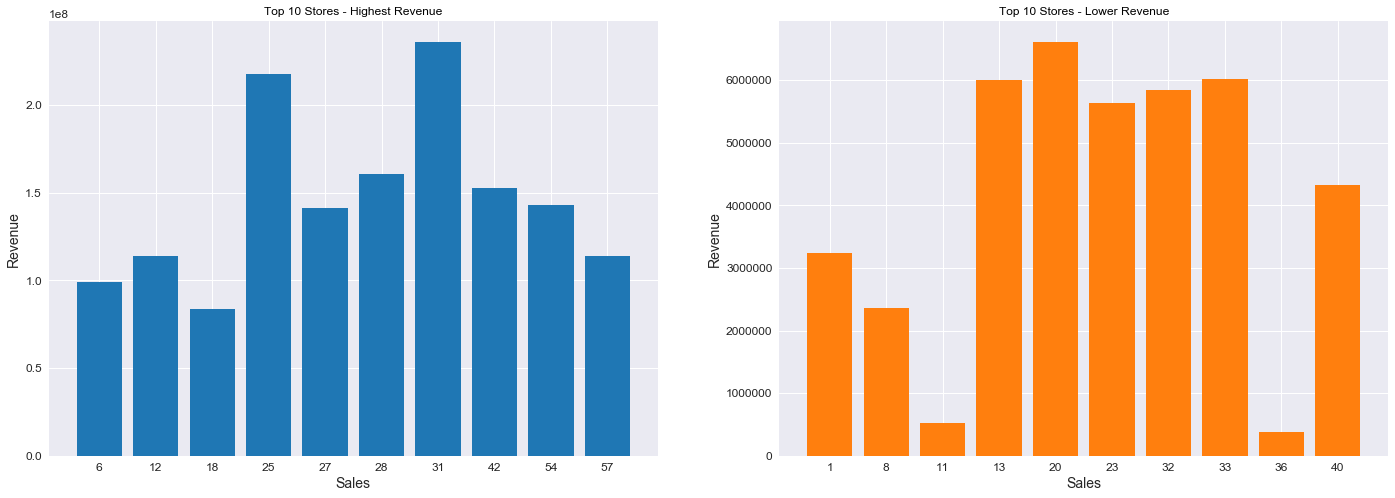

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

axs[0].set_xlabel('Sales')
axs[0].set_ylabel('Revenue')
axs[0].set_title('Top 10 Stores - Highest Revenue')
axs[0].bar(stores_highest_revenue['shop_id'].astype('str'), stores_highest_revenue['total_value'], color='tab:blue')

axs[1].set_xlabel('Sales')
axs[1].set_ylabel('Revenue')
axs[1].set_title('Top 10 Stores - Lower Revenue')
axs[1].bar(stores_lower_revenue['shop_id'].astype('str'), stores_lower_revenue['total_value'], color='tab:orange')

In [27]:
sales_category = sales.groupby(['item_category_id'])['item_cnt_day'].agg(item_cnt_day='sum')
sales_category = sales_category.sort_values(by='item_cnt_day', ascending=False).astype('int')

In [28]:
category_more_sales = sales_category.iloc[0:10] # TOP 10
category_more_sales = category_more_sales.sort_values(by='item_category_id').reset_index()

category_less_sales = sales_category.iloc[-10:] # LAST 10
category_less_sales = category_less_sales.sort_values(by='item_category_id').reset_index()

<BarContainer object of 10 artists>

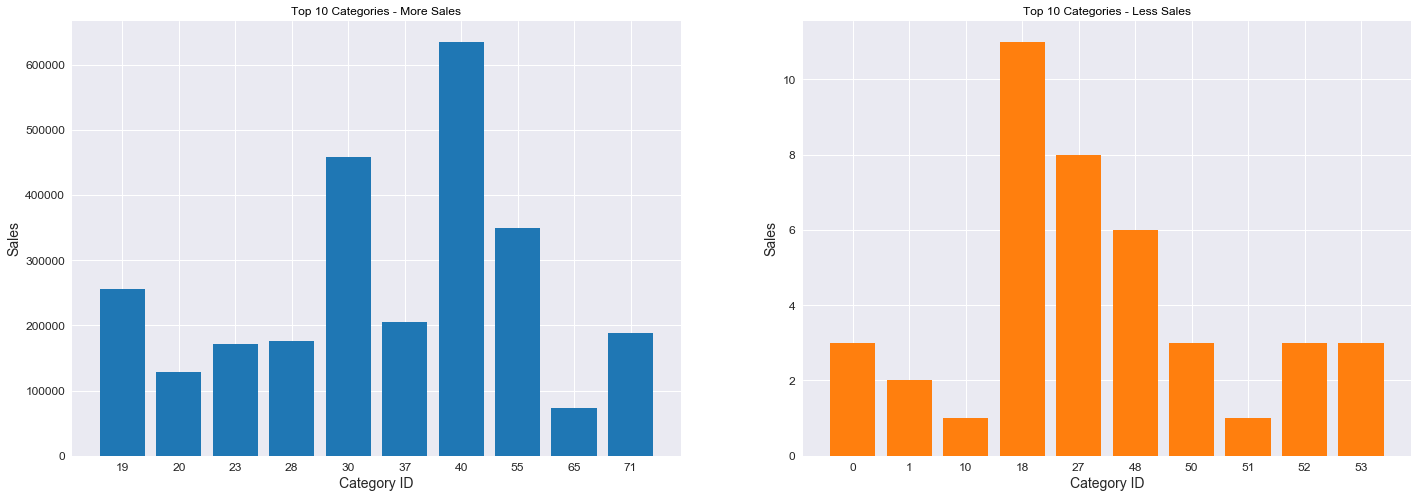

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

axs[0].set_ylabel('Sales')
axs[0].set_xlabel('Category ID')
axs[0].set_title('Top 10 Categories - More Sales')
axs[0].bar(category_more_sales['item_category_id'].astype('str'), category_more_sales['item_cnt_day'], color='tab:blue')

axs[1].set_ylabel('Sales')
axs[1].set_xlabel('Category ID')
axs[1].set_title('Top 10 Categories - Less Sales')
axs[1].bar(category_less_sales['item_category_id'].astype('str'), category_less_sales['item_cnt_day'], color='tab:orange')

### Machine Learning Model

#### Preprocessing

In [30]:
# Obtendo as datas de início e fim da série temporal.
start_date = pd.datetime.strftime(sales['date'].min(), '%Y-%m-%d')
end_date = pd.datetime.strftime(sales['date'].max(), '%Y-%m-%d')

In [31]:
# Agrupamento mensal com as somatórias de 'item_cnt_day' e 'total_value'.
total = sales.groupby(['date_block_num'])['item_cnt_day', 'total_value'].sum()
total.index = pd.date_range(start=start_date, end=end_date, freq='MS')
total = total.reset_index()

In [32]:
total.head()

,index,item_cnt_day,total_value
0,2013-01-01,132221.0,9.285109e+07
1,2013-02-01,128674.0,9.126327e+07
2,2013-03-01,147734.0,1.055981e+08
3,2013-04-01,107688.0,6.975997e+07
4,2013-05-01,107326.0,6.544102e+07


In [33]:
total_sales = total.drop('total_value', axis=1)
total_revenue = total.drop('item_cnt_day', axis=1)

#### Prophet Model

In [34]:
# Prophet reqiures a pandas df at the below config: 'DS' and 'Y'.
# DS = date column; Y = numeric and represents the measurement we wish to forecast;
total_sales.columns = ['ds', 'y']
total_revenue.columns = ['ds', 'y']

In [35]:
total_sales.head()

,ds,y
0,2013-01-01,132221.0
1,2013-02-01,128674.0
2,2013-03-01,147734.0
3,2013-04-01,107688.0
4,2013-05-01,107326.0


In [36]:
total_revenue.head()

,ds,y
0,2013-01-01,9.285109e+07
1,2013-02-01,9.126327e+07
2,2013-03-01,1.055981e+08
3,2013-04-01,6.975997e+07
4,2013-05-01,6.544102e+07


In [37]:
# Instantiate Prophet with only yearly seasonality as our data is monthly.
model_sales = Prophet(yearly_seasonality=True, interval_width=0.95)
model_sales.fit(total_sales)

model_revenue = Prophet(yearly_seasonality=True, interval_width=0.95)
model_revenue.fit(total_revenue)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Forecasts

In [38]:
# Forecast for the next 5 months.
# MS - Month Start is the frequency.
future_sales = model_sales.make_future_dataframe(periods=5, freq='MS')
future_revenue = model_revenue.make_future_dataframe(periods=5, freq='MS')

In [39]:
forecasts_sales = model_sales.predict(future_sales)
forecasts_revenue = model_revenue.predict(future_revenue)

In [40]:
forecasts_sales[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83471.690562,78751.090192,88509.719661
35,2015-12-01,125888.814065,121238.544342,130452.699699
36,2016-01-01,76082.516827,71164.174207,80363.237831
37,2016-02-01,40321.484415,35639.755546,45078.814684
38,2016-03-01,76778.364928,72065.336507,81853.132001


In [41]:
forecasts_revenue[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,1.248389e+08,1.180185e+08,1.313216e+08
35,2015-12-01,2.117112e+08,2.048177e+08,2.182039e+08
36,2016-01-01,8.874296e+07,8.205071e+07,9.527184e+07
37,2016-02-01,5.104640e+07,4.443720e+07,5.785471e+07
38,2016-03-01,9.863633e+07,9.177345e+07,1.054349e+08


#### Visualization

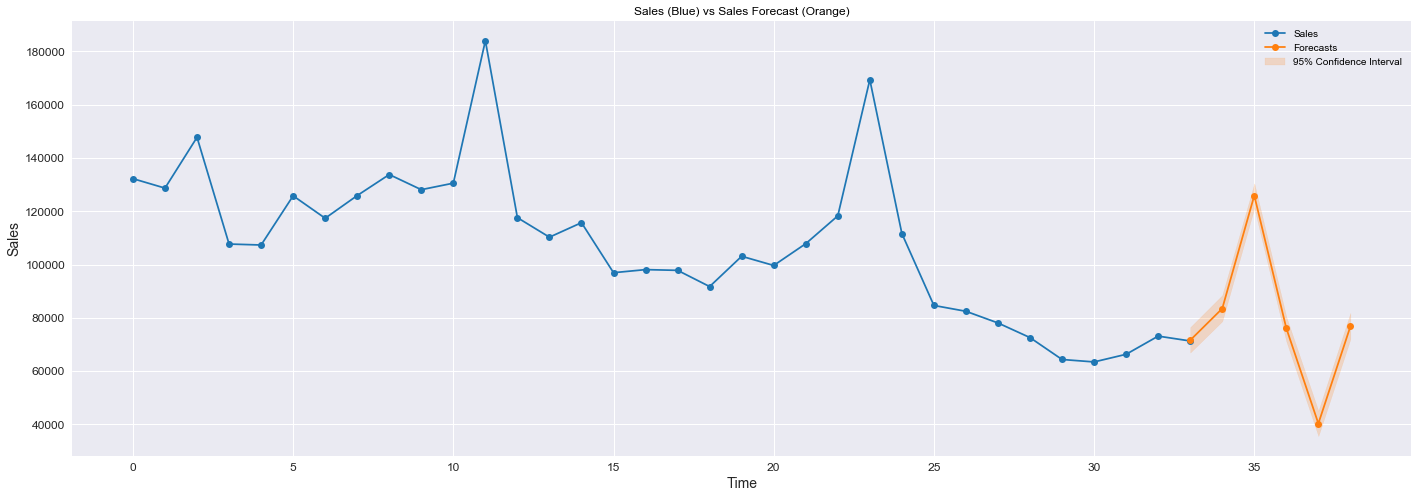

In [42]:
fig, axs = plt.subplots(figsize=(24, 8))
axs.set_title('Sales (Blue) vs Sales Forecast (Orange)')
axs.set_ylabel('Sales')
axs.set_xlabel('Time')
axs.plot(total_sales.drop('ds', axis=1), '-ok', color='tab:blue', label='Sales')
axs.plot(forecasts_sales[-6:].yhat, '-ok', color='tab:orange', label='Forecasts')
axs.fill_between(forecasts_sales[-6:].index, forecasts_sales[-6:].yhat_upper, forecasts_sales[-6:].yhat_lower,
                 alpha=0.2, color='tab:orange', label='95% Confidence Interval')
plt.legend()

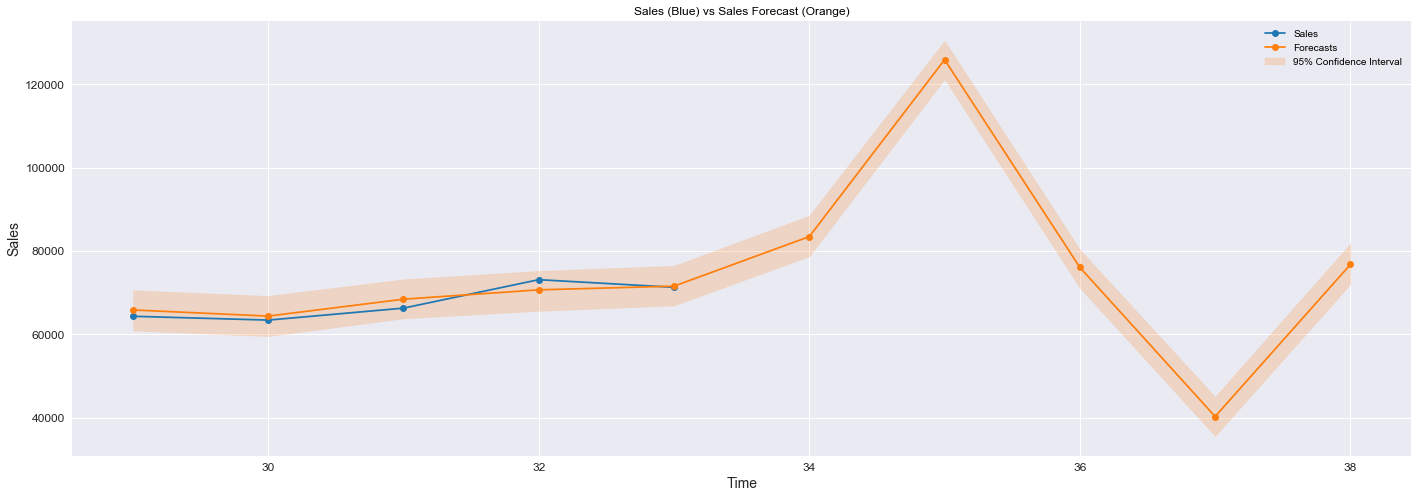

In [43]:
fig, axs = plt.subplots(figsize=(24, 8))
axs.set_title('Sales (Blue) vs Sales Forecast (Orange)')
axs.set_ylabel('Sales')
axs.set_xlabel('Time')
axs.plot(total_sales[-5:].drop('ds', axis=1), '-ok', color='tab:blue', label='Sales')
axs.plot(forecasts_sales[-10:].yhat, '-ok', color='tab:orange', label='Forecasts')
axs.fill_between(forecasts_sales[-10:].index, forecasts_sales[-10:].yhat_upper, forecasts_sales[-10:].yhat_lower,
                 alpha=0.2, color='tab:orange', label='95% Confidence Interval')
plt.legend()

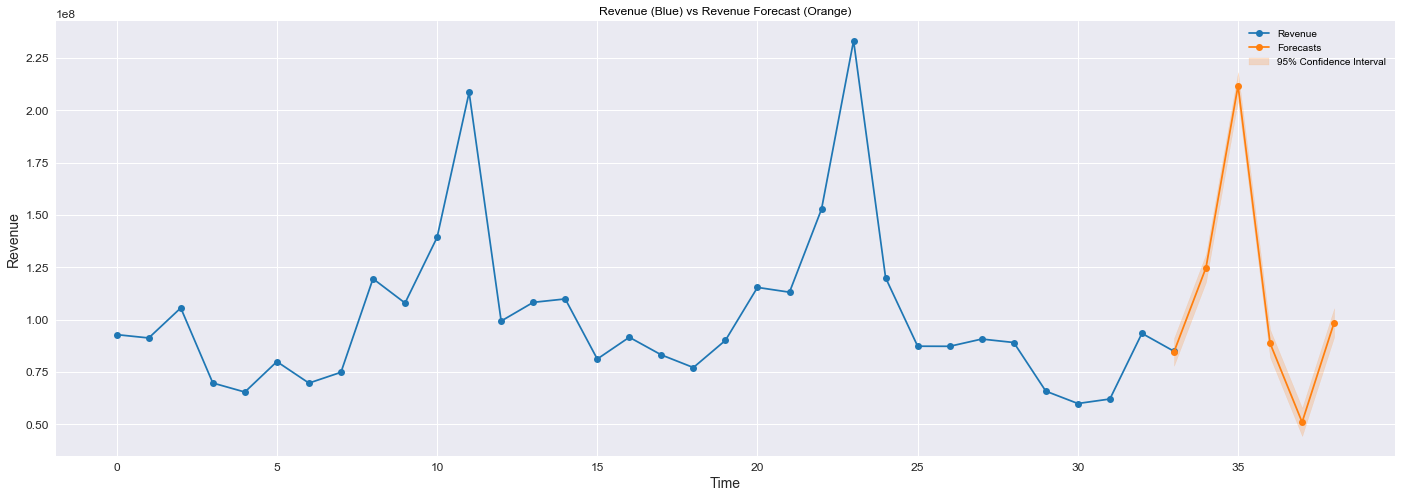

In [44]:
fig, axs = plt.subplots(figsize=(24, 8))
axs.set_title('Revenue (Blue) vs Revenue Forecast (Orange)')
axs.set_ylabel('Revenue')
axs.set_xlabel('Time')
axs.plot(total_revenue.drop('ds', axis=1), '-ok', color='tab:blue', label='Revenue')
axs.plot(forecasts_revenue[-6:].yhat, '-ok', color='tab:orange', label='Forecasts')
axs.fill_between(forecasts_revenue[-6:].index, forecasts_revenue[-6:].yhat_upper, forecasts_revenue[-6:].yhat_lower,
                 alpha=0.2, color='tab:orange', label='95% Confidence Interval')
plt.legend()